<a href="https://colab.research.google.com/github/DastanIqbal/LearnOpenCV/blob/main/src/OpenCV/dlap/week6/findTuneTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
dataset_train, info_train = tfds.load(
    'citrus_leaves',
    with_info=True,
    as_supervised=True,
    split='train[:80%]',
    shuffle_files=True
)

dataset_valid, info_valid = tfds.load(
    'citrus_leaves',
    with_info=True,
    as_supervised=True,
    split='train[80%:]',
    shuffle_files=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/594 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/citrus_leaves/incomplete.CVW6FR_0.1.2/citrus_leaves-train.tfrecord*...:   …

Dataset citrus_leaves downloaded and prepared to /root/tensorflow_datasets/citrus_leaves/0.1.2. Subsequent calls will reuse this data.


In [4]:
print(len(dataset_train))
print(len(dataset_valid))

475
119


In [5]:
label_info = info_train.features['label']
print(label_info.names)

['Black spot', 'canker', 'greening', 'healthy']


In [6]:
for example in dataset_train:
  image = example[0]
  label = example[1]
  print(image.shape, label)
  break

(256, 256, 3) tf.Tensor(1, shape=(), dtype=int64)


,image,label
0,,1 (canker)
1,,3 (healthy)
2,,2 (greening)
3,,2 (greening)
4,,1 (canker)
5,,2 (greening)
6,,1 (canker)
7,,0 (Black spot)

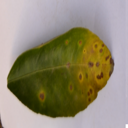
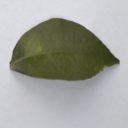
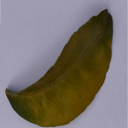
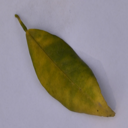
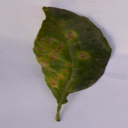
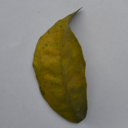
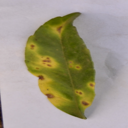
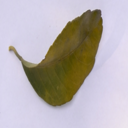

In [7]:
tfds.as_dataframe(dataset_train.take(8), info_train)

In [8]:
def preprocess(image,label):
  image = tf.image.resize(image, (224,224))
  image = tf.keras.applications.vgg16.preprocess_input(image)
  return image, label

In [9]:
train_ds = dataset_train.map(preprocess).shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = dataset_valid.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [25]:
# Load the VGG16 model
base_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = True

In [26]:
# Modified VGG16 Architecture
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(info_train.features['label'].num_classes, activation='softmax')(x)

In [27]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(
    optimizer=SGD(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [28]:
# Model Training

history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.3342 - loss: 5.5539 - val_accuracy: 0.5882 - val_loss: 1.1909
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 511ms/step - accuracy: 0.5116 - loss: 1.6245 - val_accuracy: 0.5966 - val_loss: 0.9120
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 508ms/step - accuracy: 0.5895 - loss: 1.0902 - val_accuracy: 0.6807 - val_loss: 0.7953
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 508ms/step - accuracy: 0.6388 - loss: 0.8631 - val_accuracy: 0.7227 - val_loss: 0.7347
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 507ms/step - accuracy: 0.6745 - loss: 0.8133 - val_accuracy: 0.7815 - val_loss: 0.6243
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 510ms/step - accuracy: 0.7029 - loss: 0.7922 - val_accuracy: 0.7899 - val_loss: 0.5613
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 507ms/step - accuracy: 0.7423 - loss: 0.6614 - val_accuracy: 0.7899 - val_loss: 0.5142
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - accuracy: 0.8016 - loss: 0.5198 - val_accuracy: 0

In [29]:
loss, accuracy = model.evaluate(test_ds)
print(f'Test accuracy: {accuracy:.2f}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.8931 - loss: 0.2958
Test accuracy: 0.87


Text(0.5, 1.0, 'Loss Curves')

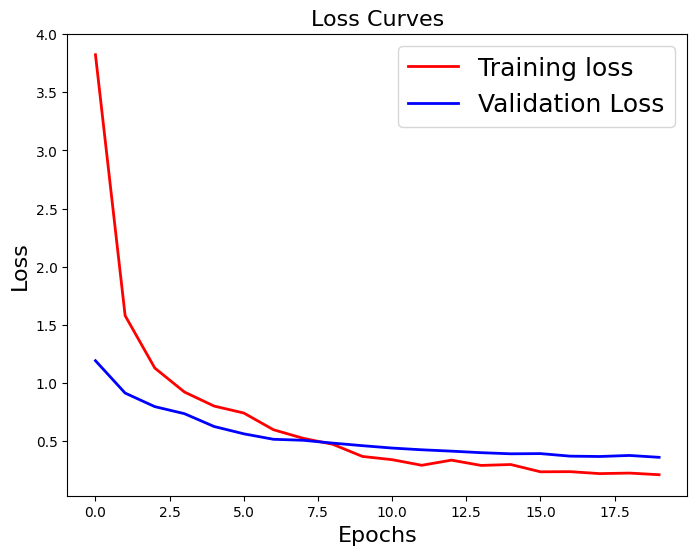

In [33]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves', fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

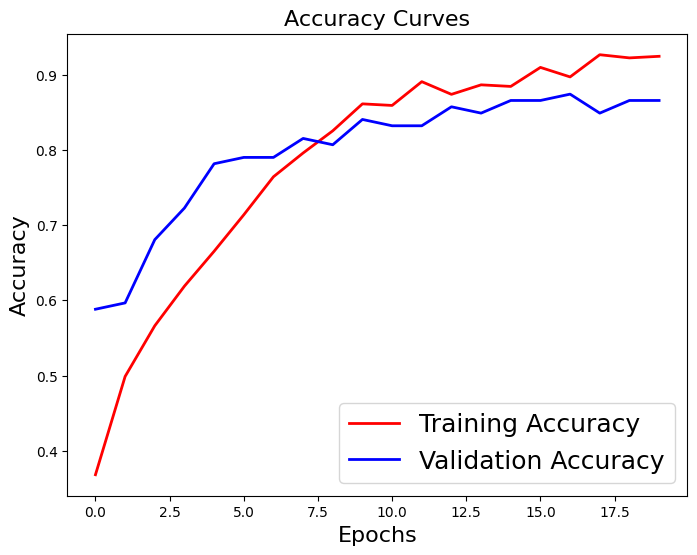

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves', fontsize=16)